In [1]:
from numpy import *
from numpy import random
from numba import jit
import matplotlib.pyplot as plt


#### Randomize lattice and calculate energy
$H = -\sum_{<r, r'>} S_r S_{r'}$

In [2]:
@jit(nopython=True)
def CEnergy(latt):
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]  
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    return array(sign(2*random.random((N,N))-1),dtype=int) 

#### Energy range $[-2N^2, -2N^2 + 4, ..., 2N^2]$

In [3]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist()
    Energies.pop(1)  
    Energies.pop(-2) 
    Energies = array(Energies) 
    Emin, Emax = Energies[0],Energies[-1]
    
    indE = -ones(Emax+1-Emin, dtype=int)
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    return (Energies, indE, Emin)

#### Wang Landau

In [4]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    (lngE, Hist) = RunWangLandau(Nitt,Energies,latt,indE)
    return (Energies,lngE, Hist)

@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) 
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist)

In [5]:
from numpy import random

flatness = 0.9
N = 4
Nitt = int(10e8)

(Energies, lngE, Hist) = WangLandau(Nitt, N, flatness)
print('Done')

4999 histogram is flat 299.0 312.5 f= 1.6487212707001282
9999 histogram is flat 319.0 312.5 f= 1.2840254166877414
11999 histogram is flat 120.0 125.0 f= 1.1331484530668263
14999 histogram is flat 179.0 187.5 f= 1.0644944589178593
18999 histogram is flat 236.0 250.0 f= 1.0317434074991028
24999 histogram is flat 352.0 375.0 f= 1.0157477085866857
31999 histogram is flat 396.0 437.5 f= 1.007843097206448
39999 histogram is flat 460.0 500.0 f= 1.0039138893383475
57999 histogram is flat 1080.0 1125.0 f= 1.0019550335910028
69999 histogram is flat 677.0 750.0 f= 1.0009770394924165
81999 histogram is flat 708.0 750.0 f= 1.0004884004786945
113999 histogram is flat 1839.0 2000.0 f= 1.0002441704297478
122999 histogram is flat 523.0 562.5 f= 1.0001220777633837
155999 histogram is flat 1860.0 2062.5 f= 1.0000610370189331
174999 histogram is flat 1073.0 1187.5 f= 1.000030518043791
195999 histogram is flat 1230.0 1312.5 f= 1.0000152589054785
246999 histogram is flat 2900.0 3187.5 f= 1.000007629423635
2

In [6]:
lngE[0],lngE[-1]

(np.float64(602.3605573157904), np.float64(602.3344988681563))

In [7]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = log(4)-lngE[-1]-log(1+exp(lngE[0]-lngE[-1]))
else:
    lgC = log(4)-lngE[0]-log(1+exp(lngE[-1]-lngE[0]))

lngE += lgC

In [8]:
exp(lngE[0])+exp(lngE[-1]), exp(lngE[0]), exp(lngE[-1])  # g[0]+g[-1]

(np.float64(3.999999999999987),
 np.float64(2.0260569731676914),
 np.float64(1.9739430268322957))

[-32 -24 -20 -16 -12  -8  -4   0   4   8  12  16  20  24  32]


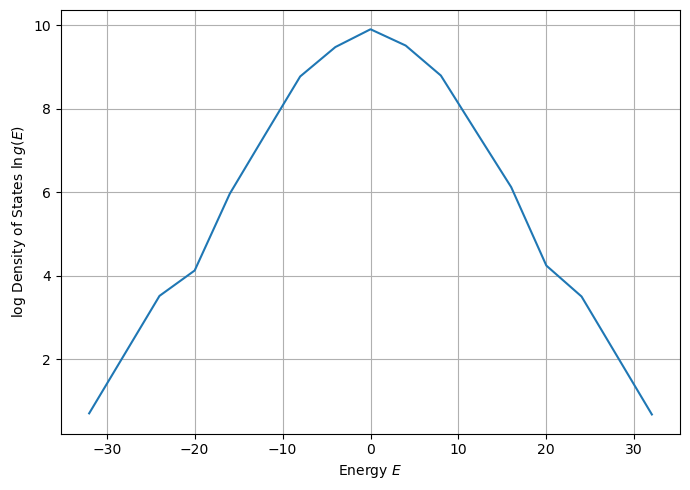

In [9]:
print(Energies)
plt.figure(figsize=(7,5))
plt.plot(Energies, lngE)
plt.xlabel("Energy $E$")
plt.ylabel("log Density of States $\\ln g(E)$")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Parition function:
$Z = \sum_{E} g[E] e^{-E/T}$

In [10]:
print(len(Energies), len(lngE))

15 15


In [11]:
print("sum(g):", sum(exp(lngE)))


sum(g): 64043.16357722163


In [12]:
import math
def partition_function(Energies, lngE, T):
    # Maximum energy
    E0 = Energies[-1]
    Z = 0
    for i, E in enumerate(Energies):
        try:
            w = float(math.exp(lngE[i] - lngE[0] - (E + E0)/T))
        except OverflowError:
            w = float('inf')
        Z += w
    return Z


Te = linspace(0.4, 6., 60)
Z = []
for T in Te:
    Z.append(partition_function(Energies, lngE,T))
Z = array(Z)

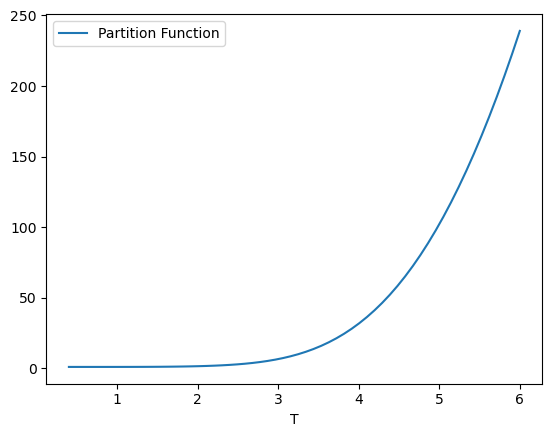

In [13]:
plt.plot(Te, Z, label='Partition Function')
plt.xlabel('T')
plt.legend(loc='best')
plt.show()

In [14]:
print(Z)

[  1.00000003   1.00000159   1.00002149   1.00014131   1.00058937
   1.00181069   1.00448871   1.00952231   1.01798571   1.03109937
   1.05022913   1.07692001   1.11296426   1.16049906   1.22212773
   1.3010571    1.40124345   1.52753948   1.6858347    1.88318272
   2.12790947   2.42969786   2.79964569   3.25029475   3.79563091
   4.4510556    5.23333061   6.16049857   7.25178228   8.5274663
  10.0087645   11.71767705  13.67684058  15.90937455  18.43872707
  21.28852257  24.48241383  28.04394006  31.9963927   36.36269019
  41.16526234  46.42594519  52.16588648  58.40546194  65.16420233
  72.46073092  80.31271119  88.73680417  97.748635   107.36276809
 117.59269019 128.45080093 139.94841    152.09574041 164.90193728
 178.37508141 192.52220724 207.34932441 222.86144273 239.06259973]


In [25]:
import numpy as np
import math
import random as r
from numba import jit
import itertools
import matplotlib.pyplot as plt

k_B = 1  # Boltzmann constant

def enumerate_partition_function(N, T):
    """
    Brute force enumeration to compute Z(T).
    """
    n_sites = N*N
    Z = 0.0
    for spins in itertools.product([-1, 1], repeat=n_sites):
        # Convert spins tuple to N x N lattice
        latt = np.array(spins).reshape((N, N))
        E = CEnergy(latt, N)
        Z += math.exp(-E / (k_B * T))
    return Z



sign = lambda x : math.copysign(1, x)

@jit(nopython=True)
def CEnergy(latt, N):
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            Ene += -S*WF
    return int(Ene/2)

def RandomL(N):
    latt = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*r.random() - 1)
    return latt


N = 5  
Te = np.linspace(0.4, 6.0, 1)
Z_exact = []
print(f"Enumerating all {2**(N*N):,} configurations for N={N} ...")
# for T in Te:
#     Z_exact.append(enumerate_partition_function(N, T))
# Z_exact = np.array(Z_exact)
Z_exact.append(enumerate_partition_function(N, T=1))

print(Z_exact)

Enumerating all 33,554,432 configurations for N=5 ...
[1.0460093374573526e+22]


In [24]:
print(Z_exact)

[5973.916645008712]
